<a href="https://colab.research.google.com/github/Lxyyxxx/Colab/blob/main/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install loguru

     |████████████████████████████████| 57 kB 3.3 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
from loguru import logger
from typing import Any, Tuple, List

In [ ]:
class Actor(tf.keras.Model):
    def __init__(self, n_action: int, alpha: float) -> None:
        super(Actor, self).__init__()
        self.w_init = tf.keras.initializers.RandomNormal(0, .1)
        self.b_init = tf.keras.initializers.constant(.1)
        self.n_action = n_action
        self.alpha = alpha
        self.loss_fn = tf.keras.losses.sparse_categorical_crossentropy
        self.optimizer_fn = tf.keras.optimizers.Adam(alpha)
        self.nn = [
            tf.keras.layers.Dense(20, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            tf.keras.layers.Dense(self.n_action, activation='softmax', kernel_initializer=self.w_init, bias_initializer=self.b_init)
        ]

    def call(self, x):
        for layer in self.nn:
            x = layer(x)
        return x

    def predict(self, state: Any) -> int:
        probs = self(state)
        action = tf.random.categorical(probs, 1)[0, 0].numpy()
        return action

    @tf.function
    def learn(self, state: tf.Tensor, action: tf.Tensor, advantage: tf.Tensor) -> None:
        with tf.GradientTape() as tape:
            loss = tf.multiply(self.loss_fn(action, self(state)), advantage)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fn.apply_gradients(zip(grads, self.trainable_variables))

    def save_model(self) -> None:
        self.save('actor')

    def load_model(self) -> None:
        self = tf.keras.models.load_model('actor')

In [ ]:
class Critic(tf.keras.Model):
    def __init__(self, n_action: int, alpha: float, gamma: float) -> None:
        super(Critic, self).__init__()
        self.w_init = tf.keras.initializers.RandomNormal(0, .1)
        self.b_init = tf.keras.initializers.constant(.1)
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.loss_fn = tf.keras.losses.mse
        self.optimizer_fn = tf.keras.optimizers.Adam(self.alpha)
        self.nn = [
            tf.keras.layers.Dense(20, activation='relu', kernel_initializer=self.w_init, bias_initializer=self.b_init),
            tf.keras.layers.Dense(1, kernel_initializer=self.w_init, bias_initializer=self.b_init)
        ]

    def call(self, x):
        for layer in self.nn:
            x = layer(x)
        return x

    @tf.function
    def learn(self, state: tf.Tensor, reward: tf.Tensor, state_: tf.Tensor, not_done: tf.Tensor) -> tf.Tensor:
        with tf.GradientTape() as tape:
            y_true = reward + self.gamma * self(state_) * not_done
            y_pred = self(state)
            loss = self.loss_fn(y_true, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer_fn.apply_gradients(zip(grads, self.trainable_variables))
        td_error = y_true - y_pred
        return td_error

    def save_model(self) -> None:
        self.save('critic')

    def load_model(self) -> None:
        self = tf.keras.models.load_model('critic')

image.png

In [ ]:
class ActorCriticAgent():
    def __init__(
        self,
        action_n: int,
        alpha_q: float = 0.01,
        alpha_p: float = 0.001,
        gamma: float = 0.9,
    ) -> None:
        self.actor = Actor(action_n, alpha_p)
        self.critic = Critic(action_n, alpha_q, gamma)

    def predict(self, state) -> int:
        return self.actor.predict(state)

    def learn(self, state, action: int, reward: float, state_, not_done: bool) -> None:
        td_error = self.critic.learn(state, reward, state_, not_done)
        self.actor.learn(state, action, td_error)

    def save_model(self) -> None:
        self.actor.save_model()
        self.critic.save_model()

    def load_model(self) -> None:
        self.actor.load_model()
        self.critic.load_model()

In [ ]:
def run_episode(env: gym.Wrapper, agent: ActorCriticAgent, training: bool, render: bool = False) -> float:
    state = env.reset()
    state = tf.constant(tf.expand_dims(state, 0))
    done = False
    score = 0
    while not done:
        if render:
            env.render()
        action = agent.predict(state)
        state_, reward, done, info = env.step(action)
        score += reward
        state = tf.constant(tf.expand_dims(state, 0))
        action = tf.constant([action])
        reward = tf.constant(reward)
        state_ = tf.constant(tf.expand_dims(state_, 0))
        not_done = tf.constant(1 - done, dtype=tf.float32)
        if training:
            agent.learn(state, action, reward, state_, not_done)
        state = state_
    return score

In [ ]:
def train(env: gym.Wrapper, agent: ActorCriticAgent) -> None:
    score_result = []
    max_score = 0
    for episode in range(1000):
        score = run_episode(env, agent, training=True)
        score_result.append(score)
        if score > max_score:
            max_score = score
            logger.info('Episode {}: Best score {}'.format(episode, score))
        if score == max_score:
            agent.save_model()
        if episode % 50 == 0:
            logger.info('Episode {}: score {}'.format(episode, score))
    plt.title('Train Score Curve')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()


def play(env: gym.Wrapper, agent: ActorCriticAgent) -> None:
    score_result = []
    agent.load_model()
    for episode in range(5):
        score = run_episode(env, agent, training=False, render=False)
        score_result.append(score)
        logger.info('Round {}: score: {}'.format(episode, score))
    plt.title('Play Score Curve')
    plt.xlabel('Round')
    plt.ylabel('Score')
    plt.plot(score_result, label='$Score$')
    plt.legend()
    plt.show()

2021-10-13 07:46:24.068 | INFO     | __main__:train:9 - Episode 0: Best score 17.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:25.135 | INFO     | __main__:train:13 - Episode 0: score 17.0
2021-10-13 07:46:25.221 | INFO     | __main__:train:9 - Episode 2: Best score 19.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:26.197 | INFO     | __main__:train:9 - Episode 3: Best score 38.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:27.098 | INFO     | __main__:train:9 - Episode 5: Best score 41.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:29.048 | INFO     | __main__:train:9 - Episode 28: Best score 43.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:30.776 | INFO     | __main__:train:9 - Episode 49: Best score 99.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:31.575 | INFO     | __main__:train:13 - Episode 50: score 22.0
2021-10-13 07:46:33.210 | INFO     | __main__:train:9 - Episode 71: Best score 146.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:36.062 | INFO     | __main__:train:13 - Episode 100: score 28.0
2021-10-13 07:46:40.054 | INFO     | __main__:train:13 - Episode 150: score 71.0
2021-10-13 07:46:45.205 | INFO     | __main__:train:13 - Episode 200: score 108.0
2021-10-13 07:46:48.094 | INFO     | __main__:train:9 - Episode 221: Best score 149.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:50.318 | INFO     | __main__:train:9 - Episode 228: Best score 153.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:52.672 | INFO     | __main__:train:9 - Episode 237: Best score 159.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:55.144 | INFO     | __main__:train:13 - Episode 250: score 30.0
2021-10-13 07:46:55.477 | INFO     | __main__:train:9 - Episode 251: Best score 166.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:56.605 | INFO     | __main__:train:9 - Episode 253: Best score 169.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:46:57.826 | INFO     | __main__:train:9 - Episode 255: Best score 186.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:47:01.303 | INFO     | __main__:train:9 - Episode 270: Best score 196.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:47:02.800 | INFO     | __main__:train:9 - Episode 274: Best score 199.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:47:06.177 | INFO     | __main__:train:9 - Episode 289: Best score 200.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:47:10.706 | INFO     | __main__:train:13 - Episode 300: score 18.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:47:24.539 | INFO     | __main__:train:13 - Episode 350: score 196.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

2021-10-13 07:47:46.107 | INFO     | __main__:train:13 - Episode 400: score 200.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:48:03.212 | INFO     | __main__:train:13 - Episode 450: score 200.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

2021-10-13 07:48:24.702 | INFO     | __main__:train:13 - Episode 500: score 22.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:48:42.275 | INFO     | __main__:train:13 - Episode 550: score 49.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:49:00.577 | INFO     | __main__:train:13 - Episode 600: score 200.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

2021-10-13 07:49:21.110 | INFO     | __main__:train:13 - Episode 650: score 200.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:49:39.178 | INFO     | __main__:train:13 - Episode 700: score 178.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

2021-10-13 07:49:59.929 | INFO     | __main__:train:13 - Episode 750: score 107.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:50:16.845 | INFO     | __main__:train:13 - Episode 800: score 86.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:50:35.628 | INFO     | __main__:train:13 - Episode 850: score 28.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets


2021-10-13 07:50:53.713 | INFO     | __main__:train:13 - Episode 900: score 72.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

2021-10-13 07:51:15.766 | INFO     | __main__:train:13 - Episode 950: score 82.0


INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written to: actor/assets
INFO:tensorflow:Assets written to: critic/assets
INFO:tensorflow:Assets written

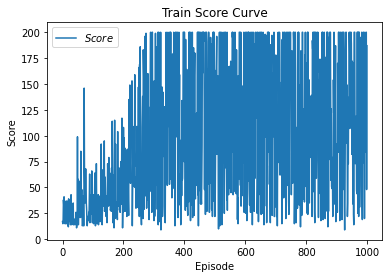

2021-10-13 07:51:40.075 | INFO     | __main__:play:28 - Round 0: score: 200.0
2021-10-13 07:51:40.172 | INFO     | __main__:play:28 - Round 1: score: 93.0
2021-10-13 07:51:40.199 | INFO     | __main__:play:28 - Round 2: score: 22.0
2021-10-13 07:51:40.396 | INFO     | __main__:play:28 - Round 3: score: 200.0
2021-10-13 07:51:40.533 | INFO     | __main__:play:28 - Round 4: score: 131.0


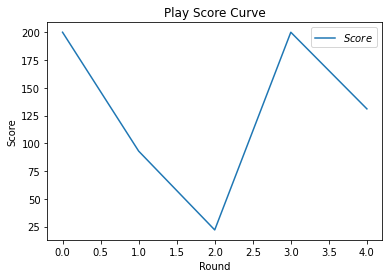

In [ ]:
if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    agent = ActorCriticAgent(env.action_space.n)
    train(env, agent)
    play(env, agent)